# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=150  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, out_planes//2, kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes//2, one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        #out = self.bn1(self.conv1(x))
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = F.tanh(w) # [-0.5,+0.5]
        #w=F.relu6(w) # 效果大大折扣
        
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        #out = self.bn2(out)
        out=F.relu6(self.bn2(out))

            
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, (256,2), (256,1), (512,2), [512,1], [512,1], [512,1],[512,1], [512,1], [1024,2], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
# writer = SummaryWriter()
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.317187, Accuracy: 10.16
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.739555, Accuracy: 9.38
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.468929, Accuracy: 9.77
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.271804, Accuracy: 11.72
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.214532, Accuracy: 16.80
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.125456, Accuracy: 18.36
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.063283, Accuracy: 18.75
Train Epoch: 0 [8960/50000 (20%)]	Loss: 1.957888, Accuracy: 25.39
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.006796, Accuracy: 23.05
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.940412, Accuracy: 26.56
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.925677, Accuracy: 23.83
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.894595, Accuracy: 26.95
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.874364, Accuracy: 28.12
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.920679, Accuracy: 23.83
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.921081, Accuracy: 26.95
Train Epoch:

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.002285, Accuracy: 61.33
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.100897, Accuracy: 63.67
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.001543, Accuracy: 62.50
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.066111, Accuracy: 62.50
Train Epoch: 3 [19200/50000 (43%)]	Loss: 0.999437, Accuracy: 63.67
Train Epoch: 3 [20480/50000 (45%)]	Loss: 0.896160, Accuracy: 64.84
Train Epoch: 3 [21760/50000 (48%)]	Loss: 0.990526, Accuracy: 65.62
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.004177, Accuracy: 63.67
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.030357, Accuracy: 63.67
Train Epoch: 3 [25600/50000 (57%)]	Loss: 0.837519, Accuracy: 69.14
Train Epoch: 3 [26880/50000 (60%)]	Loss: 0.920745, Accuracy: 68.75
Train Epoch: 3 [28160/50000 (62%)]	Loss: 0.988273, Accuracy: 62.50
Train Epoch: 3 [29440/50000 (65%)]	Loss: 0.974446, Accuracy: 64.06
Train Epoch: 3 [30720/50000 (68%)]	Loss: 0.866317, Accuracy: 67.97
Train Epoch: 3 [32000/50000 (71%)]	Loss: 0.905450, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.704397, Accuracy: 76.17
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.739517, Accuracy: 72.27
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.671808, Accuracy: 75.39
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.717396, Accuracy: 75.00
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.702695, Accuracy: 73.44
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.789652, Accuracy: 75.39
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.763403, Accuracy: 72.27
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.790211, Accuracy: 75.00
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.731040, Accuracy: 75.78
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.748385, Accuracy: 75.78
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.784371, Accuracy: 71.88
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.544778, Accuracy: 82.03
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.620572, Accuracy: 77.34
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.601540, Accuracy: 78.52
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.689037, Accuracy: 7

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.559870, Accuracy: 80.08
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.501429, Accuracy: 85.16
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.604673, Accuracy: 81.25
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.631826, Accuracy: 78.91
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.523867, Accuracy: 82.50

Validation set: Average loss: 0.6508, Accuracy: 3936/5000 (78.00%)

the time of this epoch:[21.43558931350708 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.698342, Accuracy: 76.17
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.479366, Accuracy: 83.59
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.473839, Accuracy: 81.64
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.513023, Accuracy: 83.98
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.514213, Accuracy: 83.20
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.463158, Accuracy: 83.20
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.553520, Accuracy: 81.25
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.540901, Accuracy: 82.42
Train Epoch: 10 [10240

Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.423779, Accuracy: 84.77
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.471316, Accuracy: 82.81
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.317101, Accuracy: 90.62
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.475564, Accuracy: 84.77
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.445709, Accuracy: 83.98
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.506993, Accuracy: 82.42
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.427775, Accuracy: 83.20
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.471664, Accuracy: 81.25
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.505752, Accuracy: 78.12
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.506504, Accuracy: 83.59
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.544897, Accuracy: 83.98
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.437409, Accuracy: 84.77
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.473282, Accuracy: 84.77
Train Epoch: 13 [19200/50000 (43%)]	Loss: 0.453111, Accuracy: 85.16
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.535842, Accu

Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.442264, Accuracy: 85.94
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.488379, Accuracy: 86.72
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.346645, Accuracy: 87.50
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.382793, Accuracy: 87.11
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.417352, Accuracy: 86.33
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.418866, Accuracy: 85.16
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.554143, Accuracy: 81.25
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.607496, Accuracy: 80.86
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.405321, Accuracy: 85.94
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.415325, Accuracy: 84.77
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.426344, Accuracy: 85.16
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.434556, Accuracy: 85.16
Train Epoch: 16 [29440/50000 (65%)]	Loss: 0.499840, Accuracy: 82.03
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.575733, Accuracy: 80.08
Train Epoch: 16 [32000/50000 (71%)]	Loss: 0.3520

Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.346747, Accuracy: 88.28
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.341145, Accuracy: 88.28
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.441644, Accuracy: 83.98
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.402923, Accuracy: 87.89
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.370942, Accuracy: 85.94
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.368174, Accuracy: 86.33
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.371050, Accuracy: 85.16
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.354309, Accuracy: 87.50
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.423765, Accuracy: 82.81
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.411034, Accuracy: 86.33
Train Epoch: 19 [38400/50000 (85%)]	Loss: 0.395071, Accuracy: 85.16
Train Epoch: 19 [39680/50000 (88%)]	Loss: 0.351977, Accuracy: 87.89
Train Epoch: 19 [40960/50000 (91%)]	Loss: 0.412741, Accuracy: 85.16
Train Epoch: 19 [42240/50000 (94%)]	Loss: 0.578038, Accuracy: 81.64
Train Epoch: 19 [43520/50000 (97%)]	Loss: 0.2737

Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.290400, Accuracy: 90.62
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.240611, Accuracy: 91.41
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.319886, Accuracy: 88.67
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.326107, Accuracy: 90.23
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.282395, Accuracy: 89.06
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.290910, Accuracy: 87.50
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.353229, Accuracy: 90.00

Validation set: Average loss: 0.3865, Accuracy: 4348/5000 (86.00%)

the time of this epoch:[21.41311240196228 s]
Train Epoch: 23 [0/50000 (0%)]	Loss: 0.234393, Accuracy: 93.75
Train Epoch: 23 [1280/50000 (3%)]	Loss: 0.243730, Accuracy: 91.80
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.244459, Accuracy: 91.02
Train Epoch: 23 [3840/50000 (9%)]	Loss: 0.233951, Accuracy: 93.75
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.226083, Accuracy: 92.97
Train Epoch: 23 [6400/50000 (14%)]	Loss: 0.205470, Accuracy: 93.75
Train Epoch: 23

Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.342268, Accuracy: 86.72
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.263716, Accuracy: 89.45
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.182385, Accuracy: 93.36
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.217192, Accuracy: 92.58
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.286073, Accuracy: 88.67
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.220696, Accuracy: 92.19
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.210260, Accuracy: 91.80
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.229457, Accuracy: 92.97
Train Epoch: 26 [11520/50000 (26%)]	Loss: 0.363508, Accuracy: 87.50
Train Epoch: 26 [12800/50000 (28%)]	Loss: 0.253410, Accuracy: 92.58
Train Epoch: 26 [14080/50000 (31%)]	Loss: 0.290617, Accuracy: 88.28
Train Epoch: 26 [15360/50000 (34%)]	Loss: 0.246841, Accuracy: 91.80
Train Epoch: 26 [16640/50000 (37%)]	Loss: 0.241133, Accuracy: 91.41
Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.306086, Accuracy: 89.84
Train Epoch: 26 [19200/50000 (43%)]	Loss: 0.248210, Accura

Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.247632, Accuracy: 92.58
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.293280, Accuracy: 88.28
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.293673, Accuracy: 90.23
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.227685, Accuracy: 92.97
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.257773, Accuracy: 91.02
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.153936, Accuracy: 94.53
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.213975, Accuracy: 92.19
Train Epoch: 29 [21760/50000 (48%)]	Loss: 0.253461, Accuracy: 89.84
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.210595, Accuracy: 92.58
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.237949, Accuracy: 91.02
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.309837, Accuracy: 90.62
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.268749, Accuracy: 89.84
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.217280, Accuracy: 90.62
Train Epoch: 29 [29440/50000 (65%)]	Loss: 0.256739, Accuracy: 92.97
Train Epoch: 29 [30720/50000 (68%)]	Loss: 0.2987

Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.194132, Accuracy: 92.97
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.263106, Accuracy: 91.41
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.300133, Accuracy: 89.84
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.214539, Accuracy: 93.75
Train Epoch: 32 [29440/50000 (65%)]	Loss: 0.202845, Accuracy: 93.36
Train Epoch: 32 [30720/50000 (68%)]	Loss: 0.208586, Accuracy: 91.41
Train Epoch: 32 [32000/50000 (71%)]	Loss: 0.201535, Accuracy: 92.19
Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.197197, Accuracy: 90.23
Train Epoch: 32 [34560/50000 (77%)]	Loss: 0.244330, Accuracy: 91.41
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.253096, Accuracy: 89.84
Train Epoch: 32 [37120/50000 (82%)]	Loss: 0.210273, Accuracy: 94.53
Train Epoch: 32 [38400/50000 (85%)]	Loss: 0.232215, Accuracy: 91.41
Train Epoch: 32 [39680/50000 (88%)]	Loss: 0.314824, Accuracy: 91.02
Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.229243, Accuracy: 91.02
Train Epoch: 32 [42240/50000 (94%)]	Loss: 0.2441

Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.190513, Accuracy: 92.97
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.159127, Accuracy: 93.75
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.251494, Accuracy: 91.80
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.181698, Accuracy: 92.58
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.174544, Accuracy: 94.53
Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.195041, Accuracy: 93.75
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.242345, Accuracy: 90.62
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.196269, Accuracy: 91.50

Validation set: Average loss: 0.3879, Accuracy: 4372/5000 (87.00%)

the time of this epoch:[21.399486780166626 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.149582, Accuracy: 94.53
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.222138, Accuracy: 91.41
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.209770, Accuracy: 94.14
Train Epoch: 36 [3840/50000 (9%)]	Loss: 0.188243, Accuracy: 93.75
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.164061, Accuracy: 93.75
Train Epoch: 

Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.232121, Accuracy: 91.41
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.184038, Accuracy: 92.97
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.198745, Accuracy: 94.92
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.126360, Accuracy: 95.31
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.176930, Accuracy: 92.97
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.169190, Accuracy: 94.92
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.143111, Accuracy: 94.14
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.193106, Accuracy: 92.97
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.245322, Accuracy: 89.84
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.142399, Accuracy: 94.92
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.279097, Accuracy: 89.45
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.171037, Accuracy: 92.97
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.187598, Accuracy: 92.97
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.230832, Accuracy: 91.02
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.239380, Accura

Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.148961, Accuracy: 94.53
Train Epoch: 42 [14080/50000 (31%)]	Loss: 0.127880, Accuracy: 94.92
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.136094, Accuracy: 94.92
Train Epoch: 42 [16640/50000 (37%)]	Loss: 0.087718, Accuracy: 97.27
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.111652, Accuracy: 95.31
Train Epoch: 42 [19200/50000 (43%)]	Loss: 0.138007, Accuracy: 95.31
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.142608, Accuracy: 95.31
Train Epoch: 42 [21760/50000 (48%)]	Loss: 0.208162, Accuracy: 91.41
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.145097, Accuracy: 93.75
Train Epoch: 42 [24320/50000 (54%)]	Loss: 0.167948, Accuracy: 94.53
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.190191, Accuracy: 94.14
Train Epoch: 42 [26880/50000 (60%)]	Loss: 0.140129, Accuracy: 95.70
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.125888, Accuracy: 95.31
Train Epoch: 42 [29440/50000 (65%)]	Loss: 0.136463, Accuracy: 92.97
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.1422

Train Epoch: 45 [24320/50000 (54%)]	Loss: 0.142178, Accuracy: 93.36
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.109939, Accuracy: 96.48
Train Epoch: 45 [26880/50000 (60%)]	Loss: 0.109662, Accuracy: 96.48
Train Epoch: 45 [28160/50000 (62%)]	Loss: 0.174683, Accuracy: 94.14
Train Epoch: 45 [29440/50000 (65%)]	Loss: 0.115820, Accuracy: 96.48
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.180597, Accuracy: 91.80
Train Epoch: 45 [32000/50000 (71%)]	Loss: 0.153743, Accuracy: 92.19
Train Epoch: 45 [33280/50000 (74%)]	Loss: 0.115973, Accuracy: 96.88
Train Epoch: 45 [34560/50000 (77%)]	Loss: 0.126262, Accuracy: 96.09
Train Epoch: 45 [35840/50000 (80%)]	Loss: 0.081456, Accuracy: 97.66
Train Epoch: 45 [37120/50000 (82%)]	Loss: 0.097929, Accuracy: 96.48
Train Epoch: 45 [38400/50000 (85%)]	Loss: 0.083215, Accuracy: 97.66
Train Epoch: 45 [39680/50000 (88%)]	Loss: 0.156946, Accuracy: 93.75
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.125523, Accuracy: 96.09
Train Epoch: 45 [42240/50000 (94%)]	Loss: 0.1490

Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.132785, Accuracy: 96.88
Train Epoch: 48 [37120/50000 (82%)]	Loss: 0.079143, Accuracy: 97.66
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.107186, Accuracy: 95.70
Train Epoch: 48 [39680/50000 (88%)]	Loss: 0.150653, Accuracy: 94.92
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.168616, Accuracy: 93.75
Train Epoch: 48 [42240/50000 (94%)]	Loss: 0.128151, Accuracy: 96.09
Train Epoch: 48 [43520/50000 (97%)]	Loss: 0.111227, Accuracy: 96.48
Train Epoch: 48 [35000/50000 (99%)]	Loss: 0.124781, Accuracy: 95.50

Validation set: Average loss: 0.3922, Accuracy: 4421/5000 (88.00%)

the time of this epoch:[21.443223476409912 s]
Train Epoch: 49 [0/50000 (0%)]	Loss: 0.147933, Accuracy: 95.31
Train Epoch: 49 [1280/50000 (3%)]	Loss: 0.164236, Accuracy: 92.97
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.102138, Accuracy: 95.70
Train Epoch: 49 [3840/50000 (9%)]	Loss: 0.152885, Accuracy: 94.53
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.110285, Accuracy: 95.70
Train Epoch: 

Train Epoch: 52 [1280/50000 (3%)]	Loss: 0.104939, Accuracy: 95.70
Train Epoch: 52 [2560/50000 (6%)]	Loss: 0.131971, Accuracy: 96.09
Train Epoch: 52 [3840/50000 (9%)]	Loss: 0.115354, Accuracy: 95.70
Train Epoch: 52 [5120/50000 (11%)]	Loss: 0.104603, Accuracy: 96.48
Train Epoch: 52 [6400/50000 (14%)]	Loss: 0.129875, Accuracy: 93.75
Train Epoch: 52 [7680/50000 (17%)]	Loss: 0.060986, Accuracy: 97.27
Train Epoch: 52 [8960/50000 (20%)]	Loss: 0.102479, Accuracy: 96.09
Train Epoch: 52 [10240/50000 (23%)]	Loss: 0.119257, Accuracy: 94.92
Train Epoch: 52 [11520/50000 (26%)]	Loss: 0.127732, Accuracy: 96.09
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.115556, Accuracy: 94.92
Train Epoch: 52 [14080/50000 (31%)]	Loss: 0.157308, Accuracy: 95.70
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.139462, Accuracy: 94.14
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.118838, Accuracy: 96.09
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.135043, Accuracy: 94.92
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.112994, Accura

Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.059674, Accuracy: 98.83
Train Epoch: 55 [14080/50000 (31%)]	Loss: 0.154287, Accuracy: 94.92
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.117040, Accuracy: 96.09
Train Epoch: 55 [16640/50000 (37%)]	Loss: 0.066256, Accuracy: 98.83
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.124848, Accuracy: 95.70
Train Epoch: 55 [19200/50000 (43%)]	Loss: 0.101256, Accuracy: 96.48
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.097290, Accuracy: 96.09
Train Epoch: 55 [21760/50000 (48%)]	Loss: 0.084995, Accuracy: 96.48
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.055907, Accuracy: 97.66
Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.102942, Accuracy: 96.48
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.193235, Accuracy: 93.36
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.115858, Accuracy: 96.88
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.094895, Accuracy: 97.66
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.170044, Accuracy: 94.14
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.2768

Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.052689, Accuracy: 98.44
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.096973, Accuracy: 96.48
Train Epoch: 58 [26880/50000 (60%)]	Loss: 0.123833, Accuracy: 96.48
Train Epoch: 58 [28160/50000 (62%)]	Loss: 0.061920, Accuracy: 98.05
Train Epoch: 58 [29440/50000 (65%)]	Loss: 0.099897, Accuracy: 97.27
Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.040162, Accuracy: 98.44
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.081028, Accuracy: 96.88
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.118592, Accuracy: 95.70
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.050512, Accuracy: 98.83
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.091718, Accuracy: 96.09
Train Epoch: 58 [37120/50000 (82%)]	Loss: 0.117267, Accuracy: 96.09
Train Epoch: 58 [38400/50000 (85%)]	Loss: 0.104097, Accuracy: 95.70
Train Epoch: 58 [39680/50000 (88%)]	Loss: 0.157671, Accuracy: 94.92
Train Epoch: 58 [40960/50000 (91%)]	Loss: 0.138754, Accuracy: 95.31
Train Epoch: 58 [42240/50000 (94%)]	Loss: 0.0900

Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.062030, Accuracy: 97.66
Train Epoch: 61 [37120/50000 (82%)]	Loss: 0.047579, Accuracy: 98.05
Train Epoch: 61 [38400/50000 (85%)]	Loss: 0.102669, Accuracy: 96.48
Train Epoch: 61 [39680/50000 (88%)]	Loss: 0.084550, Accuracy: 96.88
Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.083697, Accuracy: 98.05
Train Epoch: 61 [42240/50000 (94%)]	Loss: 0.099748, Accuracy: 97.66
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.096808, Accuracy: 96.88
Train Epoch: 61 [35000/50000 (99%)]	Loss: 0.058908, Accuracy: 98.00

Validation set: Average loss: 0.4082, Accuracy: 4458/5000 (89.00%)

the time of this epoch:[21.380900859832764 s]
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.096817, Accuracy: 96.48
Train Epoch: 62 [1280/50000 (3%)]	Loss: 0.104727, Accuracy: 96.48
Train Epoch: 62 [2560/50000 (6%)]	Loss: 0.071415, Accuracy: 97.66
Train Epoch: 62 [3840/50000 (9%)]	Loss: 0.065315, Accuracy: 98.05
Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.065890, Accuracy: 97.66
Train Epoch: 

Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.049484, Accuracy: 98.44
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.060850, Accuracy: 97.66
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.059853, Accuracy: 98.05
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.088819, Accuracy: 95.70
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.092617, Accuracy: 96.88
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.066186, Accuracy: 97.66
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.054830, Accuracy: 98.05
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.062972, Accuracy: 97.27
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.056397, Accuracy: 99.22
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.061942, Accuracy: 97.66
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.104614, Accuracy: 95.31
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.061954, Accuracy: 98.44
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.036737, Accuracy: 99.22
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.039508, Accuracy: 98.83
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.045946, Accura

Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.061019, Accuracy: 98.05
Train Epoch: 68 [14080/50000 (31%)]	Loss: 0.071609, Accuracy: 97.66
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.062898, Accuracy: 97.27
Train Epoch: 68 [16640/50000 (37%)]	Loss: 0.067549, Accuracy: 97.66
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.076558, Accuracy: 96.88
Train Epoch: 68 [19200/50000 (43%)]	Loss: 0.053912, Accuracy: 98.44
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.025879, Accuracy: 99.61
Train Epoch: 68 [21760/50000 (48%)]	Loss: 0.034807, Accuracy: 98.44
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.048023, Accuracy: 98.44
Train Epoch: 68 [24320/50000 (54%)]	Loss: 0.056774, Accuracy: 97.66
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.058919, Accuracy: 97.66
Train Epoch: 68 [26880/50000 (60%)]	Loss: 0.030867, Accuracy: 98.83
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.064333, Accuracy: 98.05
Train Epoch: 68 [29440/50000 (65%)]	Loss: 0.067610, Accuracy: 97.27
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.0684

Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.081072, Accuracy: 97.27
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.068956, Accuracy: 96.48
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.082253, Accuracy: 96.88
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.059046, Accuracy: 98.83
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.084539, Accuracy: 98.05
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.022138, Accuracy: 99.22
Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.084792, Accuracy: 98.44
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.067143, Accuracy: 96.88
Train Epoch: 71 [34560/50000 (77%)]	Loss: 0.028199, Accuracy: 98.44
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.118911, Accuracy: 96.88
Train Epoch: 71 [37120/50000 (82%)]	Loss: 0.063068, Accuracy: 97.66
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.034134, Accuracy: 98.05
Train Epoch: 71 [39680/50000 (88%)]	Loss: 0.038733, Accuracy: 98.05
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.053657, Accuracy: 98.44
Train Epoch: 71 [42240/50000 (94%)]	Loss: 0.0232

Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.056486, Accuracy: 98.05
Train Epoch: 74 [37120/50000 (82%)]	Loss: 0.080560, Accuracy: 96.48
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.033828, Accuracy: 99.22
Train Epoch: 74 [39680/50000 (88%)]	Loss: 0.046898, Accuracy: 98.44
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.066693, Accuracy: 98.05
Train Epoch: 74 [42240/50000 (94%)]	Loss: 0.041528, Accuracy: 98.05
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.029422, Accuracy: 98.83
Train Epoch: 74 [35000/50000 (99%)]	Loss: 0.051550, Accuracy: 99.00

Validation set: Average loss: 0.4652, Accuracy: 4467/5000 (89.00%)

the time of this epoch:[21.329355478286743 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.050363, Accuracy: 97.66
Train Epoch: 75 [1280/50000 (3%)]	Loss: 0.014504, Accuracy: 100.00
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.068719, Accuracy: 98.05
Train Epoch: 75 [3840/50000 (9%)]	Loss: 0.058558, Accuracy: 98.44
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.032198, Accuracy: 98.44
Train Epoch:

Train Epoch: 78 [1280/50000 (3%)]	Loss: 0.036840, Accuracy: 98.44
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.053419, Accuracy: 98.05
Train Epoch: 78 [3840/50000 (9%)]	Loss: 0.048208, Accuracy: 98.05
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.072920, Accuracy: 96.09
Train Epoch: 78 [6400/50000 (14%)]	Loss: 0.033911, Accuracy: 98.05
Train Epoch: 78 [7680/50000 (17%)]	Loss: 0.033609, Accuracy: 99.22
Train Epoch: 78 [8960/50000 (20%)]	Loss: 0.061048, Accuracy: 98.05
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.078170, Accuracy: 96.48
Train Epoch: 78 [11520/50000 (26%)]	Loss: 0.013262, Accuracy: 99.22
Train Epoch: 78 [12800/50000 (28%)]	Loss: 0.100242, Accuracy: 97.27
Train Epoch: 78 [14080/50000 (31%)]	Loss: 0.048360, Accuracy: 98.44
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.061530, Accuracy: 97.66
Train Epoch: 78 [16640/50000 (37%)]	Loss: 0.022776, Accuracy: 99.22
Train Epoch: 78 [17920/50000 (40%)]	Loss: 0.040081, Accuracy: 98.83
Train Epoch: 78 [19200/50000 (43%)]	Loss: 0.030540, Accura

Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.026297, Accuracy: 98.83
Train Epoch: 81 [14080/50000 (31%)]	Loss: 0.051022, Accuracy: 98.44
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.047478, Accuracy: 98.44
Train Epoch: 81 [16640/50000 (37%)]	Loss: 0.032544, Accuracy: 98.44
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.030268, Accuracy: 99.22
Train Epoch: 81 [19200/50000 (43%)]	Loss: 0.030300, Accuracy: 98.83
Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.038702, Accuracy: 97.66
Train Epoch: 81 [21760/50000 (48%)]	Loss: 0.072926, Accuracy: 97.66
Train Epoch: 81 [23040/50000 (51%)]	Loss: 0.031309, Accuracy: 98.83
Train Epoch: 81 [24320/50000 (54%)]	Loss: 0.022300, Accuracy: 99.22
Train Epoch: 81 [25600/50000 (57%)]	Loss: 0.060520, Accuracy: 98.05
Train Epoch: 81 [26880/50000 (60%)]	Loss: 0.041067, Accuracy: 98.44
Train Epoch: 81 [28160/50000 (62%)]	Loss: 0.037073, Accuracy: 98.05
Train Epoch: 81 [29440/50000 (65%)]	Loss: 0.020595, Accuracy: 98.83
Train Epoch: 81 [30720/50000 (68%)]	Loss: 0.0727

Train Epoch: 84 [24320/50000 (54%)]	Loss: 0.013745, Accuracy: 99.61
Train Epoch: 84 [25600/50000 (57%)]	Loss: 0.035851, Accuracy: 98.44
Train Epoch: 84 [26880/50000 (60%)]	Loss: 0.039362, Accuracy: 98.05
Train Epoch: 84 [28160/50000 (62%)]	Loss: 0.039932, Accuracy: 97.66
Train Epoch: 84 [29440/50000 (65%)]	Loss: 0.029839, Accuracy: 98.83
Train Epoch: 84 [30720/50000 (68%)]	Loss: 0.058069, Accuracy: 98.44
Train Epoch: 84 [32000/50000 (71%)]	Loss: 0.059193, Accuracy: 97.66
Train Epoch: 84 [33280/50000 (74%)]	Loss: 0.022945, Accuracy: 99.22
Train Epoch: 84 [34560/50000 (77%)]	Loss: 0.030402, Accuracy: 98.83
Train Epoch: 84 [35840/50000 (80%)]	Loss: 0.025175, Accuracy: 99.22
Train Epoch: 84 [37120/50000 (82%)]	Loss: 0.023099, Accuracy: 98.83
Train Epoch: 84 [38400/50000 (85%)]	Loss: 0.033191, Accuracy: 98.44
Train Epoch: 84 [39680/50000 (88%)]	Loss: 0.066786, Accuracy: 98.83
Train Epoch: 84 [40960/50000 (91%)]	Loss: 0.028347, Accuracy: 98.83
Train Epoch: 84 [42240/50000 (94%)]	Loss: 0.0268

Train Epoch: 87 [35840/50000 (80%)]	Loss: 0.042402, Accuracy: 99.22
Train Epoch: 87 [37120/50000 (82%)]	Loss: 0.058016, Accuracy: 97.66
Train Epoch: 87 [38400/50000 (85%)]	Loss: 0.047482, Accuracy: 98.83
Train Epoch: 87 [39680/50000 (88%)]	Loss: 0.036073, Accuracy: 98.83
Train Epoch: 87 [40960/50000 (91%)]	Loss: 0.032041, Accuracy: 98.44
Train Epoch: 87 [42240/50000 (94%)]	Loss: 0.048129, Accuracy: 98.44
Train Epoch: 87 [43520/50000 (97%)]	Loss: 0.052721, Accuracy: 97.27
Train Epoch: 87 [35000/50000 (99%)]	Loss: 0.056939, Accuracy: 97.00

Validation set: Average loss: 0.4996, Accuracy: 4476/5000 (89.00%)

the time of this epoch:[21.39188051223755 s]
Train Epoch: 88 [0/50000 (0%)]	Loss: 0.033222, Accuracy: 98.83
Train Epoch: 88 [1280/50000 (3%)]	Loss: 0.018729, Accuracy: 99.22
Train Epoch: 88 [2560/50000 (6%)]	Loss: 0.015509, Accuracy: 99.61
Train Epoch: 88 [3840/50000 (9%)]	Loss: 0.066577, Accuracy: 98.44
Train Epoch: 88 [5120/50000 (11%)]	Loss: 0.024048, Accuracy: 99.61
Train Epoch: 8

Train Epoch: 91 [1280/50000 (3%)]	Loss: 0.040041, Accuracy: 98.44
Train Epoch: 91 [2560/50000 (6%)]	Loss: 0.038470, Accuracy: 98.83
Train Epoch: 91 [3840/50000 (9%)]	Loss: 0.034934, Accuracy: 98.05
Train Epoch: 91 [5120/50000 (11%)]	Loss: 0.035669, Accuracy: 98.83
Train Epoch: 91 [6400/50000 (14%)]	Loss: 0.030033, Accuracy: 99.22
Train Epoch: 91 [7680/50000 (17%)]	Loss: 0.028149, Accuracy: 99.22
Train Epoch: 91 [8960/50000 (20%)]	Loss: 0.045952, Accuracy: 98.44
Train Epoch: 91 [10240/50000 (23%)]	Loss: 0.019907, Accuracy: 99.22
Train Epoch: 91 [11520/50000 (26%)]	Loss: 0.041565, Accuracy: 98.44
Train Epoch: 91 [12800/50000 (28%)]	Loss: 0.010181, Accuracy: 99.61
Train Epoch: 91 [14080/50000 (31%)]	Loss: 0.022582, Accuracy: 98.83
Train Epoch: 91 [15360/50000 (34%)]	Loss: 0.058643, Accuracy: 98.44
Train Epoch: 91 [16640/50000 (37%)]	Loss: 0.028828, Accuracy: 99.22
Train Epoch: 91 [17920/50000 (40%)]	Loss: 0.026512, Accuracy: 98.44
Train Epoch: 91 [19200/50000 (43%)]	Loss: 0.041602, Accura

Train Epoch: 94 [12800/50000 (28%)]	Loss: 0.047251, Accuracy: 98.83
Train Epoch: 94 [14080/50000 (31%)]	Loss: 0.049370, Accuracy: 97.66
Train Epoch: 94 [15360/50000 (34%)]	Loss: 0.027795, Accuracy: 98.83
Train Epoch: 94 [16640/50000 (37%)]	Loss: 0.050057, Accuracy: 97.27
Train Epoch: 94 [17920/50000 (40%)]	Loss: 0.032676, Accuracy: 98.44
Train Epoch: 94 [19200/50000 (43%)]	Loss: 0.013922, Accuracy: 99.61
Train Epoch: 94 [20480/50000 (45%)]	Loss: 0.065695, Accuracy: 98.05
Train Epoch: 94 [21760/50000 (48%)]	Loss: 0.044540, Accuracy: 98.05
Train Epoch: 94 [23040/50000 (51%)]	Loss: 0.040612, Accuracy: 98.05
Train Epoch: 94 [24320/50000 (54%)]	Loss: 0.045931, Accuracy: 98.83
Train Epoch: 94 [25600/50000 (57%)]	Loss: 0.032305, Accuracy: 99.22
Train Epoch: 94 [26880/50000 (60%)]	Loss: 0.051031, Accuracy: 98.44
Train Epoch: 94 [28160/50000 (62%)]	Loss: 0.013335, Accuracy: 99.22
Train Epoch: 94 [29440/50000 (65%)]	Loss: 0.027577, Accuracy: 99.22
Train Epoch: 94 [30720/50000 (68%)]	Loss: 0.0504

Train Epoch: 97 [24320/50000 (54%)]	Loss: 0.032302, Accuracy: 98.44
Train Epoch: 97 [25600/50000 (57%)]	Loss: 0.031270, Accuracy: 98.44
Train Epoch: 97 [26880/50000 (60%)]	Loss: 0.017567, Accuracy: 98.83
Train Epoch: 97 [28160/50000 (62%)]	Loss: 0.021165, Accuracy: 99.61
Train Epoch: 97 [29440/50000 (65%)]	Loss: 0.071820, Accuracy: 98.44
Train Epoch: 97 [30720/50000 (68%)]	Loss: 0.028204, Accuracy: 98.83
Train Epoch: 97 [32000/50000 (71%)]	Loss: 0.053658, Accuracy: 97.27
Train Epoch: 97 [33280/50000 (74%)]	Loss: 0.023653, Accuracy: 98.44
Train Epoch: 97 [34560/50000 (77%)]	Loss: 0.037608, Accuracy: 99.22
Train Epoch: 97 [35840/50000 (80%)]	Loss: 0.033750, Accuracy: 99.22
Train Epoch: 97 [37120/50000 (82%)]	Loss: 0.039355, Accuracy: 98.44
Train Epoch: 97 [38400/50000 (85%)]	Loss: 0.038942, Accuracy: 98.44
Train Epoch: 97 [39680/50000 (88%)]	Loss: 0.023085, Accuracy: 98.83
Train Epoch: 97 [40960/50000 (91%)]	Loss: 0.036412, Accuracy: 98.44
Train Epoch: 97 [42240/50000 (94%)]	Loss: 0.0327

Train Epoch: 100 [34560/50000 (77%)]	Loss: 0.040485, Accuracy: 98.05
Train Epoch: 100 [35840/50000 (80%)]	Loss: 0.039985, Accuracy: 98.44
Train Epoch: 100 [37120/50000 (82%)]	Loss: 0.019404, Accuracy: 99.22
Train Epoch: 100 [38400/50000 (85%)]	Loss: 0.033203, Accuracy: 98.44
Train Epoch: 100 [39680/50000 (88%)]	Loss: 0.038184, Accuracy: 99.22
Train Epoch: 100 [40960/50000 (91%)]	Loss: 0.056188, Accuracy: 98.44
Train Epoch: 100 [42240/50000 (94%)]	Loss: 0.025611, Accuracy: 98.83
Train Epoch: 100 [43520/50000 (97%)]	Loss: 0.034795, Accuracy: 98.05
Train Epoch: 100 [35000/50000 (99%)]	Loss: 0.029796, Accuracy: 99.50

Validation set: Average loss: 0.5421, Accuracy: 4453/5000 (89.00%)

the time of this epoch:[21.31707501411438 s]
Train Epoch: 101 [0/50000 (0%)]	Loss: 0.029346, Accuracy: 99.22
Train Epoch: 101 [1280/50000 (3%)]	Loss: 0.046871, Accuracy: 98.44
Train Epoch: 101 [2560/50000 (6%)]	Loss: 0.030778, Accuracy: 98.05
Train Epoch: 101 [3840/50000 (9%)]	Loss: 0.053204, Accuracy: 98.83


Train Epoch: 103 [43520/50000 (97%)]	Loss: 0.065355, Accuracy: 98.05
Train Epoch: 103 [35000/50000 (99%)]	Loss: 0.091067, Accuracy: 97.00

Validation set: Average loss: 0.5276, Accuracy: 4473/5000 (89.00%)

the time of this epoch:[21.336154222488403 s]
Train Epoch: 104 [0/50000 (0%)]	Loss: 0.029035, Accuracy: 98.83
Train Epoch: 104 [1280/50000 (3%)]	Loss: 0.039018, Accuracy: 98.83
Train Epoch: 104 [2560/50000 (6%)]	Loss: 0.025319, Accuracy: 99.61
Train Epoch: 104 [3840/50000 (9%)]	Loss: 0.022744, Accuracy: 98.83
Train Epoch: 104 [5120/50000 (11%)]	Loss: 0.008509, Accuracy: 100.00
Train Epoch: 104 [6400/50000 (14%)]	Loss: 0.046362, Accuracy: 99.22
Train Epoch: 104 [7680/50000 (17%)]	Loss: 0.032212, Accuracy: 98.83
Train Epoch: 104 [8960/50000 (20%)]	Loss: 0.028810, Accuracy: 98.83
Train Epoch: 104 [10240/50000 (23%)]	Loss: 0.028280, Accuracy: 99.22
Train Epoch: 104 [11520/50000 (26%)]	Loss: 0.033164, Accuracy: 99.61
Train Epoch: 104 [12800/50000 (28%)]	Loss: 0.017801, Accuracy: 99.22
Tr

Train Epoch: 107 [3840/50000 (9%)]	Loss: 0.054486, Accuracy: 98.83
Train Epoch: 107 [5120/50000 (11%)]	Loss: 0.006722, Accuracy: 100.00
Train Epoch: 107 [6400/50000 (14%)]	Loss: 0.039151, Accuracy: 99.22
Train Epoch: 107 [7680/50000 (17%)]	Loss: 0.033520, Accuracy: 98.44
Train Epoch: 107 [8960/50000 (20%)]	Loss: 0.028738, Accuracy: 98.44
Train Epoch: 107 [10240/50000 (23%)]	Loss: 0.016170, Accuracy: 99.61
Train Epoch: 107 [11520/50000 (26%)]	Loss: 0.017311, Accuracy: 99.61
Train Epoch: 107 [12800/50000 (28%)]	Loss: 0.010796, Accuracy: 99.61
Train Epoch: 107 [14080/50000 (31%)]	Loss: 0.004461, Accuracy: 100.00
Train Epoch: 107 [15360/50000 (34%)]	Loss: 0.019777, Accuracy: 98.83
Train Epoch: 107 [16640/50000 (37%)]	Loss: 0.026089, Accuracy: 99.22
Train Epoch: 107 [17920/50000 (40%)]	Loss: 0.035456, Accuracy: 98.05
Train Epoch: 107 [19200/50000 (43%)]	Loss: 0.019969, Accuracy: 99.61
Train Epoch: 107 [20480/50000 (45%)]	Loss: 0.014701, Accuracy: 100.00
Train Epoch: 107 [21760/50000 (48%)]	

Train Epoch: 110 [12800/50000 (28%)]	Loss: 0.025905, Accuracy: 99.22
Train Epoch: 110 [14080/50000 (31%)]	Loss: 0.010135, Accuracy: 100.00
Train Epoch: 110 [15360/50000 (34%)]	Loss: 0.013088, Accuracy: 99.61
Train Epoch: 110 [16640/50000 (37%)]	Loss: 0.033114, Accuracy: 98.83
Train Epoch: 110 [17920/50000 (40%)]	Loss: 0.044334, Accuracy: 98.44
Train Epoch: 110 [19200/50000 (43%)]	Loss: 0.044061, Accuracy: 98.83
Train Epoch: 110 [20480/50000 (45%)]	Loss: 0.038569, Accuracy: 99.22
Train Epoch: 110 [21760/50000 (48%)]	Loss: 0.031096, Accuracy: 98.05
Train Epoch: 110 [23040/50000 (51%)]	Loss: 0.035708, Accuracy: 97.66
Train Epoch: 110 [24320/50000 (54%)]	Loss: 0.033943, Accuracy: 98.83
Train Epoch: 110 [25600/50000 (57%)]	Loss: 0.058007, Accuracy: 98.44
Train Epoch: 110 [26880/50000 (60%)]	Loss: 0.067615, Accuracy: 98.44
Train Epoch: 110 [28160/50000 (62%)]	Loss: 0.044032, Accuracy: 98.83
Train Epoch: 110 [29440/50000 (65%)]	Loss: 0.036539, Accuracy: 98.44
Train Epoch: 110 [30720/50000 (68

Train Epoch: 113 [21760/50000 (48%)]	Loss: 0.022632, Accuracy: 99.22
Train Epoch: 113 [23040/50000 (51%)]	Loss: 0.021427, Accuracy: 99.22
Train Epoch: 113 [24320/50000 (54%)]	Loss: 0.055363, Accuracy: 98.05
Train Epoch: 113 [25600/50000 (57%)]	Loss: 0.027771, Accuracy: 99.22
Train Epoch: 113 [26880/50000 (60%)]	Loss: 0.008375, Accuracy: 100.00
Train Epoch: 113 [28160/50000 (62%)]	Loss: 0.020325, Accuracy: 99.22
Train Epoch: 113 [29440/50000 (65%)]	Loss: 0.019705, Accuracy: 99.22
Train Epoch: 113 [30720/50000 (68%)]	Loss: 0.010811, Accuracy: 99.61
Train Epoch: 113 [32000/50000 (71%)]	Loss: 0.029079, Accuracy: 98.44
Train Epoch: 113 [33280/50000 (74%)]	Loss: 0.035946, Accuracy: 98.83
Train Epoch: 113 [34560/50000 (77%)]	Loss: 0.010094, Accuracy: 99.61
Train Epoch: 113 [35840/50000 (80%)]	Loss: 0.028060, Accuracy: 99.22
Train Epoch: 113 [37120/50000 (82%)]	Loss: 0.039910, Accuracy: 97.66
Train Epoch: 113 [38400/50000 (85%)]	Loss: 0.016998, Accuracy: 99.22
Train Epoch: 113 [39680/50000 (88

Train Epoch: 116 [30720/50000 (68%)]	Loss: 0.022763, Accuracy: 98.83
Train Epoch: 116 [32000/50000 (71%)]	Loss: 0.025785, Accuracy: 98.83
Train Epoch: 116 [33280/50000 (74%)]	Loss: 0.008494, Accuracy: 100.00
Train Epoch: 116 [34560/50000 (77%)]	Loss: 0.038253, Accuracy: 98.83
Train Epoch: 116 [35840/50000 (80%)]	Loss: 0.009921, Accuracy: 100.00
Train Epoch: 116 [37120/50000 (82%)]	Loss: 0.014694, Accuracy: 99.61
Train Epoch: 116 [38400/50000 (85%)]	Loss: 0.050948, Accuracy: 98.83
Train Epoch: 116 [39680/50000 (88%)]	Loss: 0.052853, Accuracy: 98.44
Train Epoch: 116 [40960/50000 (91%)]	Loss: 0.021104, Accuracy: 99.22
Train Epoch: 116 [42240/50000 (94%)]	Loss: 0.014451, Accuracy: 99.22
Train Epoch: 116 [43520/50000 (97%)]	Loss: 0.022793, Accuracy: 99.22
Train Epoch: 116 [35000/50000 (99%)]	Loss: 0.034058, Accuracy: 98.50

Validation set: Average loss: 0.5579, Accuracy: 4472/5000 (89.00%)

the time of this epoch:[21.38651704788208 s]
Train Epoch: 117 [0/50000 (0%)]	Loss: 0.037737, Accuracy

Train Epoch: 119 [39680/50000 (88%)]	Loss: 0.038174, Accuracy: 98.44
Train Epoch: 119 [40960/50000 (91%)]	Loss: 0.010043, Accuracy: 99.61
Train Epoch: 119 [42240/50000 (94%)]	Loss: 0.018556, Accuracy: 99.61
Train Epoch: 119 [43520/50000 (97%)]	Loss: 0.025061, Accuracy: 99.22
Train Epoch: 119 [35000/50000 (99%)]	Loss: 0.045473, Accuracy: 98.50

Validation set: Average loss: 0.5536, Accuracy: 4467/5000 (89.00%)

the time of this epoch:[21.31070899963379 s]
Train Epoch: 120 [0/50000 (0%)]	Loss: 0.032849, Accuracy: 98.83
Train Epoch: 120 [1280/50000 (3%)]	Loss: 0.041201, Accuracy: 98.05
Train Epoch: 120 [2560/50000 (6%)]	Loss: 0.012645, Accuracy: 99.22
Train Epoch: 120 [3840/50000 (9%)]	Loss: 0.046098, Accuracy: 98.44
Train Epoch: 120 [5120/50000 (11%)]	Loss: 0.038470, Accuracy: 99.22
Train Epoch: 120 [6400/50000 (14%)]	Loss: 0.008021, Accuracy: 100.00
Train Epoch: 120 [7680/50000 (17%)]	Loss: 0.013367, Accuracy: 99.61
Train Epoch: 120 [8960/50000 (20%)]	Loss: 0.026152, Accuracy: 99.61
Tra

Train Epoch: 123 [1280/50000 (3%)]	Loss: 0.014343, Accuracy: 99.22
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.026045, Accuracy: 98.83
Train Epoch: 123 [3840/50000 (9%)]	Loss: 0.035411, Accuracy: 98.83
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.008639, Accuracy: 100.00
Train Epoch: 123 [6400/50000 (14%)]	Loss: 0.020385, Accuracy: 99.61
Train Epoch: 123 [7680/50000 (17%)]	Loss: 0.023356, Accuracy: 98.83
Train Epoch: 123 [8960/50000 (20%)]	Loss: 0.023055, Accuracy: 99.22
Train Epoch: 123 [10240/50000 (23%)]	Loss: 0.024162, Accuracy: 98.83
Train Epoch: 123 [11520/50000 (26%)]	Loss: 0.007985, Accuracy: 100.00
Train Epoch: 123 [12800/50000 (28%)]	Loss: 0.009620, Accuracy: 100.00
Train Epoch: 123 [14080/50000 (31%)]	Loss: 0.028996, Accuracy: 98.44
Train Epoch: 123 [15360/50000 (34%)]	Loss: 0.023633, Accuracy: 98.44
Train Epoch: 123 [16640/50000 (37%)]	Loss: 0.018086, Accuracy: 99.22
Train Epoch: 123 [17920/50000 (40%)]	Loss: 0.029520, Accuracy: 98.44
Train Epoch: 123 [19200/50000 (43%)]	Loss

Train Epoch: 126 [10240/50000 (23%)]	Loss: 0.042234, Accuracy: 98.44
Train Epoch: 126 [11520/50000 (26%)]	Loss: 0.024670, Accuracy: 98.83
Train Epoch: 126 [12800/50000 (28%)]	Loss: 0.008797, Accuracy: 99.61
Train Epoch: 126 [14080/50000 (31%)]	Loss: 0.019833, Accuracy: 99.61
Train Epoch: 126 [15360/50000 (34%)]	Loss: 0.020841, Accuracy: 99.22
Train Epoch: 126 [16640/50000 (37%)]	Loss: 0.024457, Accuracy: 98.44
Train Epoch: 126 [17920/50000 (40%)]	Loss: 0.008157, Accuracy: 99.61
Train Epoch: 126 [19200/50000 (43%)]	Loss: 0.012441, Accuracy: 100.00
Train Epoch: 126 [20480/50000 (45%)]	Loss: 0.019797, Accuracy: 99.61
Train Epoch: 126 [21760/50000 (48%)]	Loss: 0.037444, Accuracy: 98.83
Train Epoch: 126 [23040/50000 (51%)]	Loss: 0.019562, Accuracy: 99.61
Train Epoch: 126 [24320/50000 (54%)]	Loss: 0.019241, Accuracy: 98.83
Train Epoch: 126 [25600/50000 (57%)]	Loss: 0.032406, Accuracy: 98.44
Train Epoch: 126 [26880/50000 (60%)]	Loss: 0.009076, Accuracy: 100.00
Train Epoch: 126 [28160/50000 (6

Train Epoch: 129 [19200/50000 (43%)]	Loss: 0.011360, Accuracy: 100.00
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.052864, Accuracy: 98.05
Train Epoch: 129 [21760/50000 (48%)]	Loss: 0.029444, Accuracy: 99.22
Train Epoch: 129 [23040/50000 (51%)]	Loss: 0.038645, Accuracy: 98.44
Train Epoch: 129 [24320/50000 (54%)]	Loss: 0.029619, Accuracy: 98.83
Train Epoch: 129 [25600/50000 (57%)]	Loss: 0.042886, Accuracy: 98.83
Train Epoch: 129 [26880/50000 (60%)]	Loss: 0.043182, Accuracy: 98.05
Train Epoch: 129 [28160/50000 (62%)]	Loss: 0.016899, Accuracy: 99.22
Train Epoch: 129 [29440/50000 (65%)]	Loss: 0.023653, Accuracy: 98.83
Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.018880, Accuracy: 99.22
Train Epoch: 129 [32000/50000 (71%)]	Loss: 0.083600, Accuracy: 97.66
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.008968, Accuracy: 99.61
Train Epoch: 129 [34560/50000 (77%)]	Loss: 0.027124, Accuracy: 98.83
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.031208, Accuracy: 98.44
Train Epoch: 129 [37120/50000 (82

Train Epoch: 132 [28160/50000 (62%)]	Loss: 0.030267, Accuracy: 98.83
Train Epoch: 132 [29440/50000 (65%)]	Loss: 0.007986, Accuracy: 100.00
Train Epoch: 132 [30720/50000 (68%)]	Loss: 0.008540, Accuracy: 99.61
Train Epoch: 132 [32000/50000 (71%)]	Loss: 0.016349, Accuracy: 99.61
Train Epoch: 132 [33280/50000 (74%)]	Loss: 0.025263, Accuracy: 98.44
Train Epoch: 132 [34560/50000 (77%)]	Loss: 0.034172, Accuracy: 99.22
Train Epoch: 132 [35840/50000 (80%)]	Loss: 0.036064, Accuracy: 98.44
Train Epoch: 132 [37120/50000 (82%)]	Loss: 0.024873, Accuracy: 98.44
Train Epoch: 132 [38400/50000 (85%)]	Loss: 0.019291, Accuracy: 99.61
Train Epoch: 132 [39680/50000 (88%)]	Loss: 0.012122, Accuracy: 99.22
Train Epoch: 132 [40960/50000 (91%)]	Loss: 0.020004, Accuracy: 99.22
Train Epoch: 132 [42240/50000 (94%)]	Loss: 0.014641, Accuracy: 99.22
Train Epoch: 132 [43520/50000 (97%)]	Loss: 0.016060, Accuracy: 99.22
Train Epoch: 132 [35000/50000 (99%)]	Loss: 0.008041, Accuracy: 100.00

Validation set: Average loss: 0

Train Epoch: 135 [37120/50000 (82%)]	Loss: 0.011214, Accuracy: 99.61
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.013693, Accuracy: 99.22
Train Epoch: 135 [39680/50000 (88%)]	Loss: 0.016246, Accuracy: 99.61
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.067063, Accuracy: 96.88
Train Epoch: 135 [42240/50000 (94%)]	Loss: 0.025893, Accuracy: 98.83
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.034944, Accuracy: 99.22
Train Epoch: 135 [35000/50000 (99%)]	Loss: 0.013952, Accuracy: 100.00

Validation set: Average loss: 0.5665, Accuracy: 4476/5000 (89.00%)

the time of this epoch:[21.303750038146973 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.028604, Accuracy: 98.83
Train Epoch: 136 [1280/50000 (3%)]	Loss: 0.020503, Accuracy: 99.22
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.006177, Accuracy: 100.00
Train Epoch: 136 [3840/50000 (9%)]	Loss: 0.031373, Accuracy: 99.22
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.021522, Accuracy: 99.61
Train Epoch: 136 [6400/50000 (14%)]	Loss: 0.008256, Accuracy: 99.61


Validation set: Average loss: 0.5695, Accuracy: 4468/5000 (89.00%)

the time of this epoch:[21.375481605529785 s]
Train Epoch: 139 [0/50000 (0%)]	Loss: 0.028809, Accuracy: 98.83
Train Epoch: 139 [1280/50000 (3%)]	Loss: 0.009386, Accuracy: 100.00
Train Epoch: 139 [2560/50000 (6%)]	Loss: 0.019787, Accuracy: 99.22
Train Epoch: 139 [3840/50000 (9%)]	Loss: 0.032244, Accuracy: 98.44
Train Epoch: 139 [5120/50000 (11%)]	Loss: 0.009156, Accuracy: 99.61
Train Epoch: 139 [6400/50000 (14%)]	Loss: 0.017421, Accuracy: 99.61
Train Epoch: 139 [7680/50000 (17%)]	Loss: 0.022565, Accuracy: 99.22
Train Epoch: 139 [8960/50000 (20%)]	Loss: 0.006151, Accuracy: 100.00
Train Epoch: 139 [10240/50000 (23%)]	Loss: 0.024377, Accuracy: 98.44
Train Epoch: 139 [11520/50000 (26%)]	Loss: 0.017545, Accuracy: 99.22
Train Epoch: 139 [12800/50000 (28%)]	Loss: 0.009919, Accuracy: 99.22
Train Epoch: 139 [14080/50000 (31%)]	Loss: 0.021291, Accuracy: 98.83
Train Epoch: 139 [15360/50000 (34%)]	Loss: 0.030286, Accuracy: 99.22
T

Train Epoch: 142 [6400/50000 (14%)]	Loss: 0.015852, Accuracy: 99.61
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.008096, Accuracy: 100.00
Train Epoch: 142 [8960/50000 (20%)]	Loss: 0.008856, Accuracy: 100.00
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.025793, Accuracy: 98.83
Train Epoch: 142 [11520/50000 (26%)]	Loss: 0.016038, Accuracy: 99.61
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.053006, Accuracy: 98.83
Train Epoch: 142 [14080/50000 (31%)]	Loss: 0.010085, Accuracy: 99.61
Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.020684, Accuracy: 98.83
Train Epoch: 142 [16640/50000 (37%)]	Loss: 0.018452, Accuracy: 98.44
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.028289, Accuracy: 99.22
Train Epoch: 142 [19200/50000 (43%)]	Loss: 0.006587, Accuracy: 100.00
Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.014985, Accuracy: 99.61
Train Epoch: 142 [21760/50000 (48%)]	Loss: 0.020437, Accuracy: 98.83
Train Epoch: 142 [23040/50000 (51%)]	Loss: 0.025229, Accuracy: 98.83
Train Epoch: 142 [24320/50000 (54%

Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.031205, Accuracy: 98.44
Train Epoch: 145 [16640/50000 (37%)]	Loss: 0.009341, Accuracy: 100.00
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.046004, Accuracy: 98.44
Train Epoch: 145 [19200/50000 (43%)]	Loss: 0.004463, Accuracy: 100.00
Train Epoch: 145 [20480/50000 (45%)]	Loss: 0.015201, Accuracy: 99.61
Train Epoch: 145 [21760/50000 (48%)]	Loss: 0.017726, Accuracy: 99.22
Train Epoch: 145 [23040/50000 (51%)]	Loss: 0.012779, Accuracy: 99.22
Train Epoch: 145 [24320/50000 (54%)]	Loss: 0.014498, Accuracy: 99.61
Train Epoch: 145 [25600/50000 (57%)]	Loss: 0.018737, Accuracy: 99.61
Train Epoch: 145 [26880/50000 (60%)]	Loss: 0.025845, Accuracy: 99.22
Train Epoch: 145 [28160/50000 (62%)]	Loss: 0.013072, Accuracy: 99.61
Train Epoch: 145 [29440/50000 (65%)]	Loss: 0.011494, Accuracy: 99.61
Train Epoch: 145 [30720/50000 (68%)]	Loss: 0.008277, Accuracy: 99.61
Train Epoch: 145 [32000/50000 (71%)]	Loss: 0.023960, Accuracy: 98.83
Train Epoch: 145 [33280/50000 (7

Train Epoch: 148 [24320/50000 (54%)]	Loss: 0.036666, Accuracy: 98.44
Train Epoch: 148 [25600/50000 (57%)]	Loss: 0.012172, Accuracy: 99.61
Train Epoch: 148 [26880/50000 (60%)]	Loss: 0.027374, Accuracy: 99.22
Train Epoch: 148 [28160/50000 (62%)]	Loss: 0.007565, Accuracy: 100.00
Train Epoch: 148 [29440/50000 (65%)]	Loss: 0.008084, Accuracy: 99.61
Train Epoch: 148 [30720/50000 (68%)]	Loss: 0.017591, Accuracy: 99.22
Train Epoch: 148 [32000/50000 (71%)]	Loss: 0.042466, Accuracy: 98.44
Train Epoch: 148 [33280/50000 (74%)]	Loss: 0.012539, Accuracy: 99.61
Train Epoch: 148 [34560/50000 (77%)]	Loss: 0.050277, Accuracy: 97.27
Train Epoch: 148 [35840/50000 (80%)]	Loss: 0.026891, Accuracy: 99.61
Train Epoch: 148 [37120/50000 (82%)]	Loss: 0.019270, Accuracy: 99.61
Train Epoch: 148 [38400/50000 (85%)]	Loss: 0.023822, Accuracy: 98.44
Train Epoch: 148 [39680/50000 (88%)]	Loss: 0.011936, Accuracy: 100.00
Train Epoch: 148 [40960/50000 (91%)]	Loss: 0.026969, Accuracy: 99.22
Train Epoch: 148 [42240/50000 (9

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6860, Accuracy: 8937/10000 (89.37%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

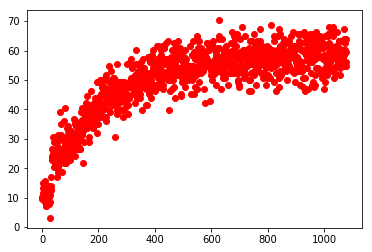

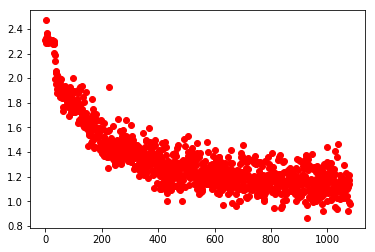

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

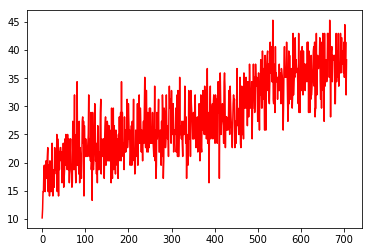

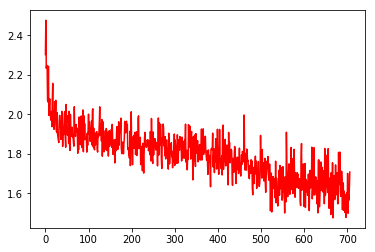

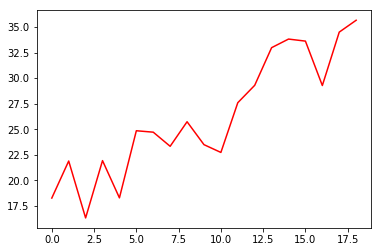

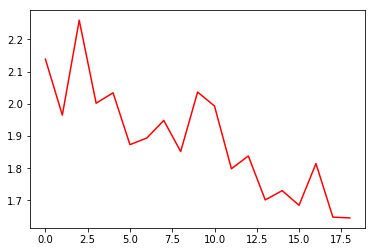

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()